# Test Battery for Clique Detection

In [132]:
# Parameters
METHOD_ID="2020-01-20 partial pairs"
# METHOD_ID="2020-01-24 all pairs"
# METHOD_ID="2020-01-25 untangled"

In [133]:
%load_ext autoreload
%autoreload 2

import networkx as nx
# import scipy
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [134]:
def evaluate_against (T, expected_paths):
    G, paths = False, False
    
    if   METHOD_ID=="2020-01-24 all pairs":
        paths = infer_paths( split_in_freqGraph( successorsGraph(  get_successor_by_freq(T, METHOD_ID="2020-01-24 all pairs")  ) ) )

        
    elif METHOD_ID=="2020-01-20 partial pairs":
        paths = infer_paths( split_in_freqGraph( successorsGraph(  get_successor_by_freq(T, METHOD_ID="2020-01-20 partial pairs")  ) ) )

        
    elif METHOD_ID=="2020-01-25 untangled":
        
        inferred_paths = infer_paths( split_in_freqGraph( successorsGraph(  get_successor_by_freq(T)  )  ) )
        
        G_aux = created_auxiliary_graph( inferred_paths )
        G = minimally_connected(G_aux)
        
        G_freq = split_in_freqGraph(G)
        for f, g1 in G_freq.items():
            graph(g1, with_weigths=True)

#         paths = { 1:[] }
# #         for f, G1 in G_freq.items():
# #             paths[f] = nx.all_shortest_paths(G, "_START_", "_END_")
            
#         for path in nx.all_simple_paths(G, "_START_", "_END_"):
#             path.remove("_START_")
#             path.remove("_END_")
#             paths[1].append( path )
        

    else:
        raise ValueError("Not valid METHOD_ID")
             
            
    if paths:
        
        G = nx.DiGraph()
        for f, path in paths.items():
            for a, b in [ (a,b) for t in path for a,b in zip( t[:-1], t[1:] )  ]:
                G.add_edge( a, b, weight=f)
        graph(G, with_weigths=True )
        
        good = []
        bad = []
        expected = [ list(a) for a in expected_paths ]
        for f, paths in paths.items():
            for p in paths:
    #             print(paths)
                if p in expected:
                    good.append("".join(p))
                else:
                    bad.append("".join(p))

        if len(expected_paths) != len(good):
            print(), print()
            print("WARNING HERE! OJO AQUI!")
            print(), print()
        print("These %s paths were correctly detected (%s undetected):" % (len(good), len(expected_paths)-len(good)))
        print(good)
        print()

        print("These %s paths are spurious:" % len(bad))
        print (bad)
        return good, bad
    else:
        return [], []

In [135]:
def created_auxiliary_graph( weighted_paths ):
    
    def append_path(G, path, weight):
        edges = []
        previous = path[0]
        for node in path[1:]:
            edges.append( (previous, node, {"weight": round(weight, 2)} ) )
            previous = node
        G.add_edges_from(edges)

    G = nx.DiGraph()
    for w in sorted(weighted_paths, reverse=True):
        for path_w in weighted_paths[w]:
            append_path( G, path_w, w )            
    return G

In [136]:
#2020-01-25
# If paths (u,z,v) and (u,v) exists, leave just (u,z,v)
def minimally_connected(G):
    G_minimal = G.copy()
    
    for u, v in G.edges():

        # u has already v, then I will work if I have more than one neighbor
        if len(G[u]) > 1:
            remove_edge = False
            # look if I have a longest u,z,v path
            for z, attr in G[u].items():
                if z != v and z != u:
                    if nx.has_path(G_minimal, z, v):
                        remove_edge = True
            if remove_edge:
                G_minimal.remove_edge( u, v )    
    return G_minimal

In [137]:
def graph(G, color="#cccccc", with_weigths=True):
    pos = nx.circular_layout(G)
    plt.rcParams['figure.figsize'] = [10, 6]
    plt.subplot(111)

    nx.draw_networkx (G, pos, width=1, node_color=color, with_labels=True, connectionstyle='arc3, rad=0.03' )
    if with_weigths:
        weights = { (str(u), str(v)): G[u][v]['weight'] for u,v in G.edges() }
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=weights)
    plt.show()

In [138]:
def get_successor_by_freq( traces, METHOD_ID="2020-01-24 all pairs" ):
    """
    Get successor pairs in every T in traces, and combine them by frequency of appearance.
    
    >>> T = [ list("ABC"), list("ABCABC") ]
    >>> get_successor_pairs_by_freq(T)
    {('A', 'B'): 3, ('A', 'C'): 3, ('B', 'C'): 3, ('B', 'A'): 1, ('C', 'A'): 1, ('C', 'B'): 1}
    """
    pairs_with_freq = {}
    L = float(len(traces))

    for trace in traces:
        for pair in get_successor_pairs(trace):
            if pair in pairs_with_freq.keys():
                pairs_with_freq[pair] = pairs_with_freq[pair] + 1.0/L
            else:
                pairs_with_freq[pair] = 1.0/L
            
    By_freq = {}
    for (u, v), freq in pairs_with_freq.items():
        f = round(freq,2)
        if f in By_freq.keys():
            By_freq[f].append( (u,v) )
        else:
            By_freq[f] =[ (u,v) ]
    return By_freq

In [139]:
def successorsGraph(successor_by_freq):
    G=nx.DiGraph()
    for f, pairs in successor_by_freq.items():
        for u, v in pairs:
            G.add_edge(u, v, weight=f)
    return G

In [140]:
# Sort the cliques and apply the rules:
# 1) The nodes of a single path in their equivalent pair has in_degree=0,1,2,...
# 2) A path is composed for at least 2 nodes

def infer_paths(G_freq, min_clique_size=2):

    paths_f = {}
    cliques_f = { f: list(nx.algorithms.clique.find_cliques( G_freq[f].to_undirected() )) for f in G_freq.keys() }
    for f, cliques in cliques_f.items():
        paths = []
        for clique in cliques:
            # From the original graph(f),
            G_complete = G_freq[f].copy()
            
            # remove the nodes not in this clique 
            for node in set(G_complete.nodes).difference( set(clique) ):
                G_complete.remove_node(node)
                
            # Order nodes by inner degree
            nodes = sorted( G_complete.in_degree() , key=lambda p: p[1], reverse=False)

            # - core - CRITERIA 1 and 2
            # Strict checking: in_degree(n) in [0, ... , len(N)-1]
            if len(nodes) >=min_clique_size and all( 
                [in_degree == i for i, (a, in_degree) in zip(range(0, len(nodes)), nodes)]
            ):
                    paths.append ( [ a for a, in_degree in nodes ] )
        if paths:
            paths_f[f] = paths
    return paths_f

In [141]:
# Including Modifications by Andres (20200124)
ADD_START_END = False
def get_successor_pairs( T_prime , ADD_START_END=ADD_START_END, METHOD_ID="2020-01-24 all pairs"):
    """
    Get near successor pairs
    
    Given the trace $T' = s_1 ... s_L$
    For every $1 <= i <= L$ find the maximal subtrace starting at $i$
    $T_i_j = s_i ... s_j$ such that $s_i \ne s_k$ for all $i < k <= j$
    
    Return the concatenation for all $T_i_j$
    [ (s_i, s_k) ] for all s_i \in T_i_j, s_k \in T_i_j for all i < k <= j
    
    ADDED 2020-01-23:
    Que no se repitan!

    
    >>> get_successor_pairs(list("ABCD"))
    [('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'C'), ('B', 'D'), ('C', 'D')]
    """
    pairs = []
    for i in range(0, len(T_prime)-1):


        partial_subtrace = T_prime[i:]

        s_i = partial_subtrace.pop(0)
        L = len(partial_subtrace)

        # Find first first j such s_i == s_j, or L if not exists
        if s_i in partial_subtrace:
            j = partial_subtrace.index(s_i)
        else:
            j = L

        # This is the subtrace T_i_j, the maximal that not contains s1
        # (Actually, it not contains s_i)
        if METHOD_ID=="2020-01-20 partial pairs":
            T_i_j=partial_subtrace[:j] # 2020-01-20 Old BEHAVIOR
        else:
            T_i_j=partial_subtrace[:L] # Andres 20200124 .. all friends with all, including loops
        
        T_i_j_pairs = [] # 2020-01-23 BEHAVIOR ... but not remove, it doesn't affect

        # Construct all s_i, s_k , i < k <= j
        for s_k in T_i_j:
            e = (s_i, s_k)

            pairs.append(e)       # 2020-01-20 Old BEHAVIOR
            
#             if e not in T_i_j_pairs:  # 2020-01-23 BEHAVIOR
#                 T_i_j_pairs.append(e) # 2020-01-23 BEHAVIOR
#         pairs += T_i_j_pairs          # 2020-01-23 BEHAVIOR
            
            
            # Added 2020-01-18: global star / end
            if ADD_START_END:
                pairs.append( ("_START_", s_i) )
                pairs.append(( s_k, "_END_") )


    return pairs

In [142]:
def split_in_freqGraph( successorsGraph ):
    u_v_f = [ (u, v, successorsGraph[u][v]["weight"]) for u, v in successorsGraph.edges]
    frqs = set([ f for u, v, f in u_v_f])
    G={}
    for f in frqs:
        G[f] = successorsGraph.copy()
        # Get all nodes whose pairs has weight!=f
        for u, v, f2 in u_v_f:
            if f != f2:
                G[f].remove_edge(u,v)
        # Remove 
    return G

## Tested examples

### Simple Loop Examples

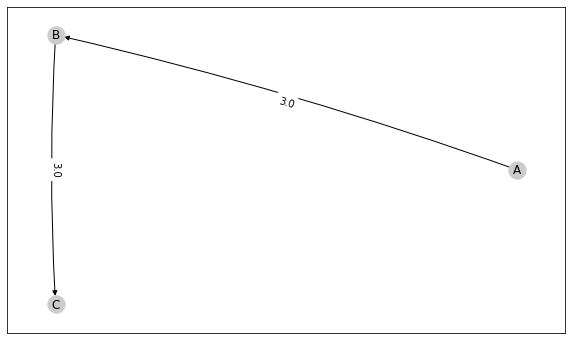

These 1 paths were correctly detected (0 undetected):
['ABC']

These 0 paths are spurious:
[]


In [143]:
T = [
    list("ABCABC"),
]
g, b = evaluate_against(T, ["ABC"] )

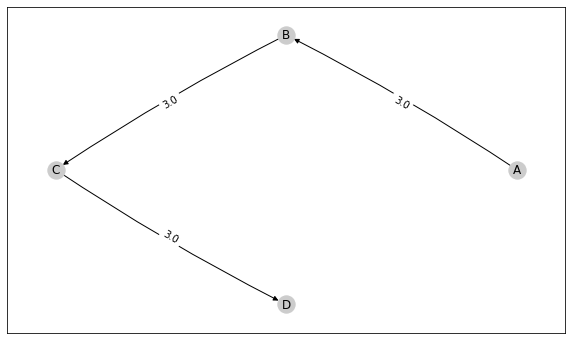

These 1 paths were correctly detected (0 undetected):
['ABCD']

These 0 paths are spurious:
[]


In [144]:
T = [
    list("ABCDABCD"),
]
g, b = evaluate_against(T, ["ABCD"] )

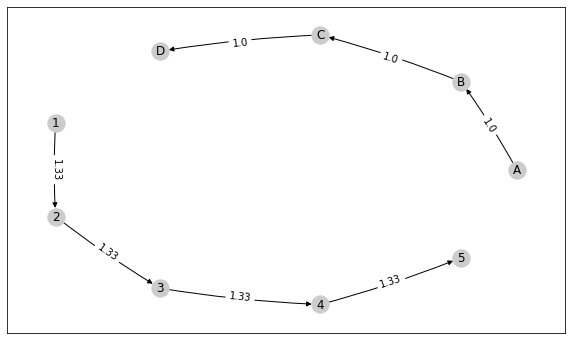

These 2 paths were correctly detected (0 undetected):
['ABCD', '12345']

These 0 paths are spurious:
[]


In [145]:
T = [
    list("ABCDABCD"),
    list("1234512345"),
    list("12345")
]
g, b = evaluate_against(T, ["ABCD", "12345"] )

### Complex Loop Examples

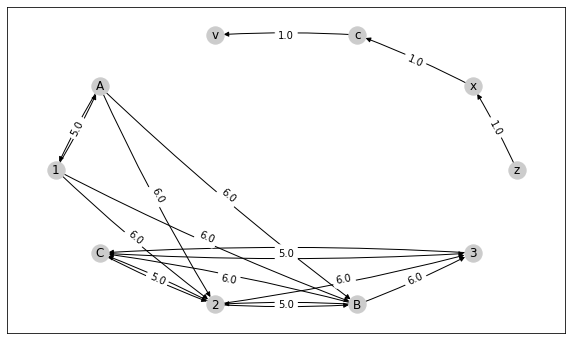

These 3 paths were correctly detected (0 undetected):
['zxcv', '123', 'ABC']

These 12 paths are spurious:
['A1', 'C2', '2B', 'C3', '1A', '2C', 'B2', '3C', '1B3', '1BC', 'A23', 'AB3']


In [146]:
# Type 75
T = [
    list("A1B23C1A2B3C1ABC23zxcv"),
]
g, b = evaluate_against(T, ("ABC", "123", "zxcv") )

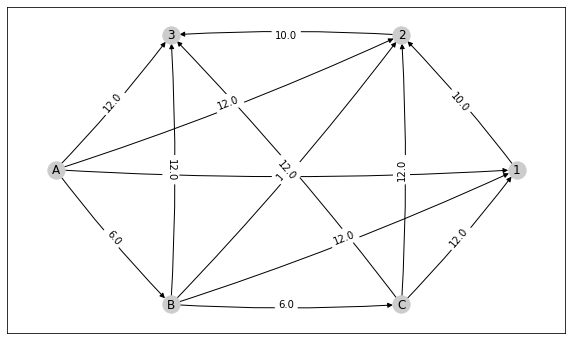

These 2 paths were correctly detected (0 undetected):
['123', 'ABC']

These 9 paths are spurious:
['A2', 'B2', 'C2', 'A3', 'B3', 'C3', 'A1', 'B1', 'C1']


In [147]:
# Type 76
T = [
    list("ABCABCABC123123123123")
]
g, b = evaluate_against(T, ("ABC", "123") )

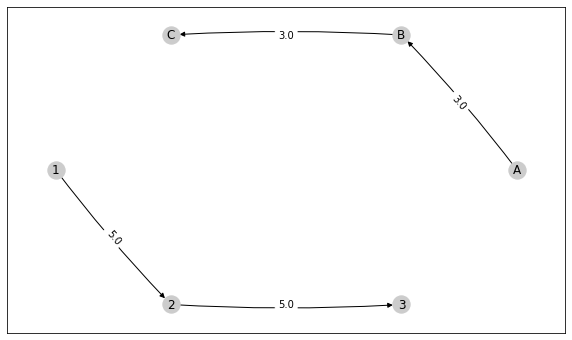

These 2 paths were correctly detected (0 undetected):
['ABC', '123']

These 0 paths are spurious:
[]


In [148]:
# Type 76-b
T = [
    list("ABCABCABC"),
    list("123123123123")
]
g, b = evaluate_against(T, ("ABC", "123") )

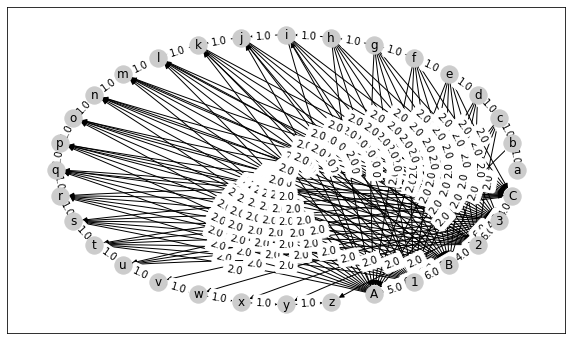

These 3 paths were correctly detected (0 undetected):
['abcdefghijklmnopqrstuvwxyz', '123', 'ABC']

These 126 paths are spurious:
['bA', '1t', '1o', '1j', 'g1', 'f1', '1s', '1r', 'e1', '1l', '1q', '1m', '1n', 'c1', 'h1', 'd1', '1i', '1k', '1p', 'Bl', 'Bm', 'hB', 'Br', 'Bo', 'gB', 'Bq', 'dB', 'Bp', 'fB', 'Bs', 'Bn', 'cB', 'iB', 'jB', 'Bt', 'eB', 'Bu', 'kB', '2l', '2m', 'h2', '2r', '2o', 'g2', '2q', 'd2', '2p', 'f2', '2s', '2n', 'c2', 'i2', 'j2', '2t', 'e2', '2u', 'k2', 'f3', '3v', '3s', 'l3', 'm3', 'n3', 'h3', '3w', 'i3', 'j3', '3r', '3t', 'o3', 'g3', 'e3', '3z', '3q', '3u', '3y', '3x', 'k3', 'p3', 'kC', 'Ct', 'oC', 'gC', 'fC', 'Cs', 'eC', 'lC', 'qC', 'mC', 'Cu', 'nC', 'hC', 'pC', 'iC', 'jC', 'Cr', 'cA', 'fA', 'As', 'Al', 'Am', 'An', 'hA', 'iA', 'Aj', 'Ar', 'At', 'Ao', 'gA', 'eA', 'Aq', 'dA', 'Ak', 'Ap', 'A1', 'C2', '2B', 'C3', '1A', '2C', 'B2', '3C', '1B3', '1BC', 'A23', 'AB3']


In [149]:
# Type 77
T = [
    list("aAb1B2cd3Cefgh1iAjk2Blmnop3qCrst1AuBC2vwxyz3"),
]
g, b = evaluate_against(T, ("ABC", "123", "abcdefghijklmnopqrstuvwxyz") )

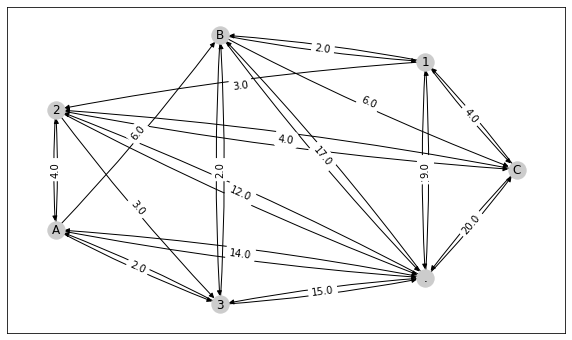

These 2 paths were correctly detected (0 undetected):
['123', 'ABC']

These 24 paths are spurious:
['C1', 'B1', '2A', 'C2', '3A', '3B', '1C', '1B', 'A2', '2C', 'A3', 'B3', '.1', '3.', '.2', '2.', '.A', '.3', '1.', '.B', 'C.', '.C', 'B.', 'A.']


In [150]:
# Type 78
T = [
    list(".1A.B2.C3..ABC...A1..2B..3C.")
]
g, b = evaluate_against(T, ("ABC", "123") )

Claim: all paths (cliques) forming a base are loops. Starting from max(f) -> min(f).

### Examples from previous notebooks

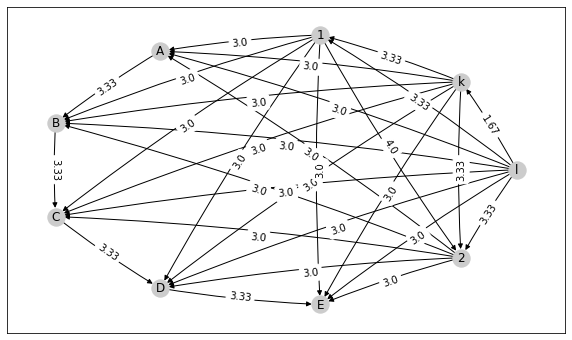

These 3 paths were correctly detected (0 undetected):
['lk', 'ABCDE', '12']

These 24 paths are spurious:
['l1', 'k1', 'l2', 'k2', 'lB', 'lE', 'lD', 'lC', 'lA', 'kB', 'kE', 'kD', 'kC', 'kA', '2B', '2E', '2D', '2C', '2A', '1B', '1E', '1D', '1C', '1A']


In [151]:
# combined_loops: lk 12 ABCDE
T = [
    list("lklk1212ABCDEABCDEABCDE1212"),
    list("lk12ABCDEABCDE"),
    list("lk12ABCDE"),
]
g, b = evaluate_against(T, ("ABCDE", "lk", "12") )

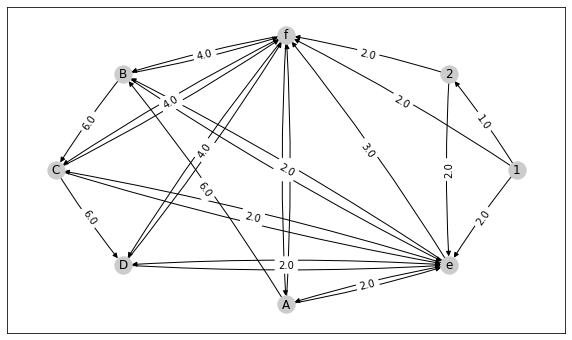

These 3 paths were correctly detected (0 undetected):
['12', 'ef', 'ABCD']

These 20 paths are spurious:
['1f', 'fB', '2f', 'fC', 'fD', 'fA', '1e', 'eB', '2e', 'eC', 'eD', 'eA', 'Df', 'Cf', 'Af', 'Bf', 'De', 'Ce', 'Ae', 'Be']


In [152]:
"""
head_with_loop = 12 ABCD* ef*

12 @ABCD @ef
"""
T = [
    list("12ABCDefABCDABCDef"),
]
g, b = evaluate_against(T, ("ABCD", "12", "ef") )

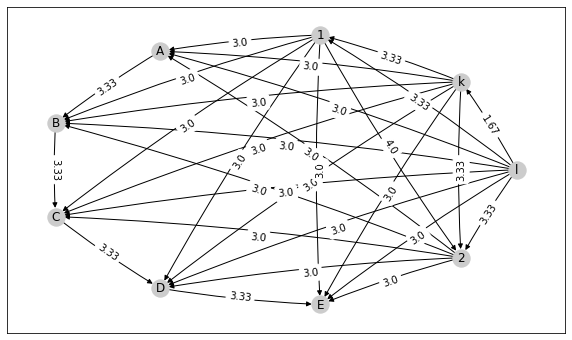

These 3 paths were correctly detected (0 undetected):
['lk', 'ABCDE', '12']

These 24 paths are spurious:
['l1', 'k1', 'l2', 'k2', 'lB', 'lE', 'lD', 'lC', 'lA', 'kB', 'kE', 'kD', 'kC', 'kA', '2B', '2E', '2D', '2C', '2A', '1B', '1E', '1D', '1C', '1A']


In [153]:
"""
  @lk - @12 - @ABCDE
"""
T = [
    list("lklk1212ABCDEABCDEABCDE1212"),
    list("lk12ABCDEABCDE"),
    list("lk12ABCDE"),
]
g, b = evaluate_against(T, ["ABCDE", "lk", "12"] )

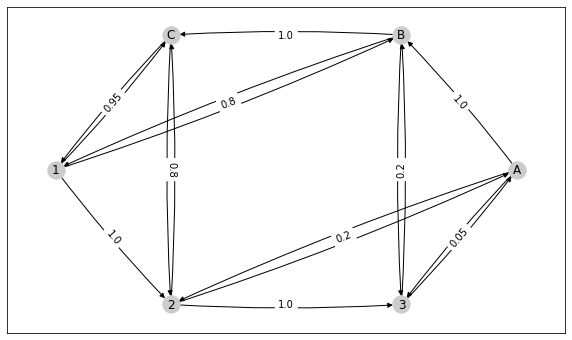

These 2 paths were correctly detected (0 undetected):
['ABC', '123']

These 12 paths are spurious:
['A2', '2C', 'B3', '1B', '2A', 'C2', '3B', 'B1', '1C', 'A3', 'C1', '3A']


In [154]:
"""
   ABC * 123        
"""
T = [ list(a) for a in ['ABC123', 'AB1C23', 'AB12C3', 'AB123C', 'A1BC23', 'A1B2C3', 'A1B23C', 
      'A12BC3', 'A12B3C', 'A123BC', '1ABC23', '1AB2C3', '1AB23C', '1A2BC3', 
      '1A2B3C', '1A23BC', '12ABC3', '12AB3C', '12A3BC', '123ABC'
]]
g, b = evaluate_against(T, ("ABC", "123") )

## Still Failing. Still...

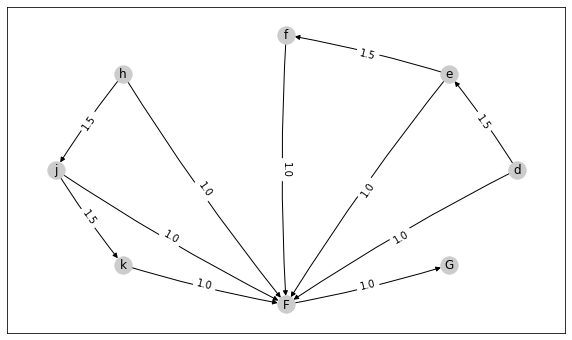



WARNING HERE! OJO AQUI!


These 2 paths were correctly detected (1 undetected):
['def', 'hjk']

These 6 paths are spurious:
['jFG', 'fFG', 'eFG', 'hFG', 'dFG', 'kFG']


In [155]:
"""
  @def 
       > FG 
  @hjk 
"""        
T = [
    list("defdefFG"),
    list("hjkhjkFG")
]
g, b = evaluate_against(T, ("hjk", "def", "FG") )

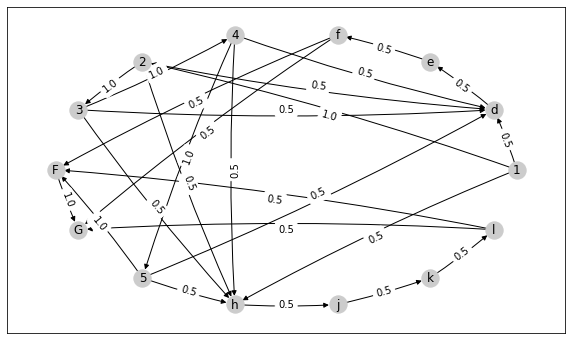



WARNING HERE! OJO AQUI!


These 1 paths were correctly detected (2 undetected):
['12345FG']

These 14 paths are spurious:
['1def', '4def', '2def', '3def', 'defF', 'defG', '5def', '1hjkl', '4hjkl', '2hjkl', '3hjkl', 'hjklF', 'hjklG', '5hjkl']


In [156]:
"""
          hjk
  12345 <     > FG
          def 
"""
T = [
    list("12345defFG"),
    list("12345hjklFG")
]
g, b = evaluate_against(T, ("12345FG", "hjkl", "def") )

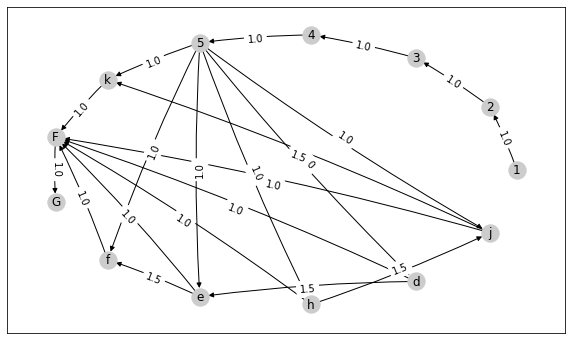



WARNING HERE! OJO AQUI!


These 2 paths were correctly detected (2 undetected):
['hjk', 'def']

These 6 paths are spurious:
['12345kFG', '12345fFG', '12345eFG', '12345hFG', '12345dFG', '12345jFG']


In [157]:
"""
          @hjk
  12345 <      > FG
          @def 
"""
T = [
    list("12345defdefFG"),
    list("12345hjkhjkFG")
]
g, b = evaluate_against(T, ["12345", "hjk", "def", "FG"] )

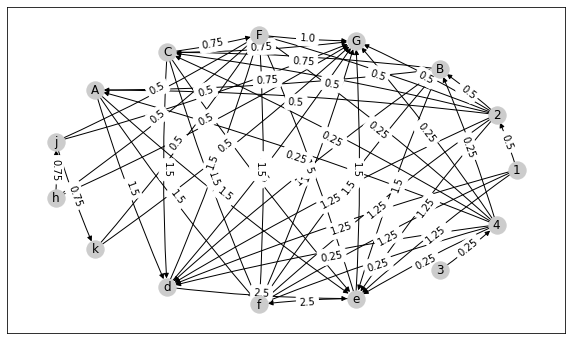



WARNING HERE! OJO AQUI!


These 3 paths were correctly detected (3 undetected):
['FG', 'hjk', 'def']

These 42 paths are spurious:
['12B', '12G', '12F', '12C', '12A', 'jG', 'jF', 'hG', 'hF', 'kG', 'kF', '1d', '1f', '1e', '2d', '2f', '2e', 'ABCG', 'ABCF', 'Bf', 'Cf', 'fF', 'fG', 'Af', 'Be', 'Ce', 'eF', 'eG', 'Ae', 'Bd', 'Cd', 'dF', 'dG', 'Ad', '34B', '34f', '34F', '34C', '34e', '34G', '34A', '34d']


In [158]:
# loop_inside = @hjk | ( (12 | 34) - ABC - @def - FG) )
"""
                     
  @hjk ----------- 
                  \
   12               > FG
       > ABC - @def 
   34 
        
"""
T = [
    list("12ABCdefdefFG"),
    list("12ABCdefdefdefFG"),
    list("34ABCdefFG"),
    list("hjkhjkFG")
]
g, b = evaluate_against(T, ("ABC", "34", "12", "hjk", "def", "FG") )

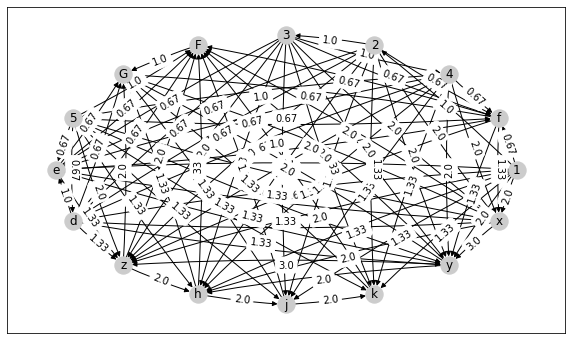



WARNING HERE! OJO AQUI!


These 2 paths were correctly detected (3 undetected):
['def', 'xyz']

These 76 paths are spurious:
['1f', '4f', '2f', '3f', 'fF', 'fG', '5f', '1e', '4e', '2e', '3e', 'eF', 'eG', '5e', '1d', '4d', '2d', '3d', 'dF', 'dG', '5d', '12345FG', '1z', '4z', '2z', '3z', 'zF', 'zG', '5z', 'zhjk', '1y', '4y', '2y', '3y', 'yF', 'yG', '5y', 'yhjk', '1x', '4x', '2x', '3x', 'xF', 'xG', '5x', 'xhjk', '1j', '4j', '2j', '3j', 'jF', 'jG', '5j', 'fz', 'fx', 'fy', 'ez', 'ex', 'ey', 'dz', 'dy', '1h', '4h', '2h', '3h', 'hF', 'hG', '5h', 'dx', '1k', '4k', '2k', '3k', 'kF', 'kG', '5k']


In [159]:
"""
          @hjk
  12345 <      > FG
          @def 
          @xyz
"""
T = [
    list("12345defdefxyzxyzFG"),
    list("12345xyzxyzhjkhjkFG"),
    list("12345hjkxyzxyzhjkFG"),

]
g, b = evaluate_against(T, ["12345", "hjk", "def", "xyz", "FG"] )